#Identifying Game Review Attribution with Alibi Gradients

Authors: Jason Phillips & Peeja Khorashadi

Date: 05/01/2023

CSC 215-01

Summary: Utilizing a dataset of Steam reviews for popular games, we are trying to identify the key attributes/words that contribute to a person recommending the game or not.

Dataset:https://www.kaggle.com/datasets/arashnic/game-review-dataset

Papers Refrenced: https://ieeexplore-ieee-org.proxy.lib.csus.edu/document/9752380 , https://ieeexplore-ieee-org.proxy.lib.csus.edu/document/9950194 , https://www.kaggle.com/code/mehmetlaudatekman/game-review-classification-deep-learning-based , https://github.com/SeldonIO/alibi

#Import and Define
Import necessary libraries and define useful functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !pip install tf-explain
# !pip install --upgrade gensim
#!pip install alibi[tensorflow]
!pip install alibi
!pip install --upgrade alibi

In [2]:
#Import and print out the current version of packages.
%load_ext tensorboard

import tensorflow as tf
#import tf_explain
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn as sk
import pandas as pd
import shutil
import os
import imblearn
import io
import requests
import datetime
import string
import torch
import random

from alibi.explainers import IntegratedGradients

from scipy.stats import zscore
from scipy import spatial

from collections.abc import Sequence
from collections import Counter
from numpy import where
from matplotlib import pyplot
import matplotlib as mpl

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Embedding
from keras.layers import Conv2D, MaxPooling2D,LSTM
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical



from gensim.models import Word2Vec, KeyedVectors
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from IPython.display import HTML

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

#Return HTML markup highlighting text with desired color.
def  hlstr(string, color='white'):
    return f"<mark style=background-color:{color}>{string} </mark>"

#Scales the colors depending on the attribution.
def colorize(attrs, cmap='PiYG'):
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors


print('Python {}'.format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))
print('Imblearn {}'.format(imblearn.__version__))

#Remove any files in the log folder for tensorboard
#!rm -rf "/content/drive/MyDrive/Colab Notebooks/logs/"

#Define the log folder for tensorboard
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Python 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Pandas 1.5.3
Numpy 1.22.4
Scikit-Learn 1.2.2

Tensor Flow 2.12.0
Keras 2.12.0
Imblearn 0.10.1


#Data Preprocessing (Training Dataset)
NOTES: 

**Should we include numbers in the tokenized text?**

**Will different genres effect our model?** 

In [44]:
#Read the review dataset from the training folder
filename_read = "https://raw.githubusercontent.com/JasonTPhillipsJr/CSC215/main/Final%20Project/train.csv"
df_train = pd.read_csv(filename_read, sep=',', header=0)
df_train

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1


In [45]:
#Print out the different games used in this review.
#NOTE: Remove the ® symbol from smite and elder scrolls later.
print("Number of titles in the dataset: " + str(df_train['title'].nunique()))
print(df_train['title'].unique())

Number of titles in the dataset: 44
["Spooky's Jump Scare Mansion" 'Sakura Clicker' 'WARMODE'
 'Fractured Space' 'Dota 2' 'Path of Exile' 'War Thunder'
 'Ring of Elysium' 'Team Fortress 2' 'Yu-Gi-Oh! Duel Links' 'SMITE®'
 'Brawlhalla' 'World of Tanks Blitz' 'DCS World Steam Edition'
 'Heroes & Generals' 'The Elder Scrolls®: Legends™' 'Trove' 'Neverwinter'
 'Realm Royale' 'PlanetSide 2' 'Realm of the Mad God' 'Elsword'
 'theHunter Classic' 'Eternal Card Game' 'Black Squad'
 'Freestyle 2: Street Basketball' 'Bless Online'
 'RaceRoom Racing Experience' 'Fallout Shelter'
 'Tactical Monsters Rumble Arena' 'Creativerse' 'Dreadnought'
 'Infestation: The New Z' 'Shop Heroes' 'Robocraft'
 'Business Tour - Board Game with Online Multiplayer'
 'Crusaders of the Lost Idols' 'AdventureQuest 3D' 'Realm Grinder'
 'World of Guns: Gun Disassembly' 'Bloons TD Battles' 'Cuisine Royale'
 'School of Dragons' 'EverQuest II']


In [46]:
#Drop unnecessary columns
df_train = df_train.drop(['review_id', 'year'], axis=1)
df_train

,title,user_review,user_suggestion
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1
...,...,...,...
17489,EverQuest II,Arguably the single greatest mmorp that exists...,1
17490,EverQuest II,"An older game, to be sure, but has its own cha...",1
17491,EverQuest II,When I frist started playing Everquest 2 it wa...,1
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1


In [47]:
#Check if any values are empty or null
df_train[df_train.isnull().any(axis=1)]

,title,user_review,user_suggestion


In [48]:
#Tokenize the tweets to get individual words per row.
tkr = RegexpTokenizer("[a-zA-Záéíóúñ']+")
df_train['tokenized'] = df_train['user_review'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
df_train

,title,user_review,user_suggestion,tokenized
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1,"[i'm, scared, and, hearing, creepy, voices, so..."
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1,"[best, game, more, better, than, sam, pepper's..."
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1,"[a, littly, iffy, on, the, controls, but, once..."
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,"[great, game, fun, and, colorful, and, all, th..."
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,"[not, many, games, have, the, cute, tag, right..."
...,...,...,...,...
17489,EverQuest II,Arguably the single greatest mmorp that exists...,1,"[arguably, the, single, greatest, mmorp, that,..."
17490,EverQuest II,"An older game, to be sure, but has its own cha...",1,"[an, older, game, to, be, sure, but, has, its,..."
17491,EverQuest II,When I frist started playing Everquest 2 it wa...,1,"[when, i, frist, started, playing, everquest, ..."
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,"[cool, game, the, only, thing, that, really, p..."


In [49]:
#Drop rows that have more than 150 words
df_train=df_train[df_train["tokenized"].str.len() <= 100]
df_train=df_train[df_train["tokenized"].str.len() > 3]
df_train=df_train[~df_train["user_review"].str.contains(r'[~@#$%^*/\|<>♥¥™_=+◕ヘ░▄▐☉ʖ]')] 
df_train

,title,user_review,user_suggestion,tokenized
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,"[great, game, fun, and, colorful, and, all, th..."
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,"[not, many, games, have, the, cute, tag, right..."
6,Spooky's Jump Scare Mansion,Great game. it's a cute little horror game tha...,1,"[great, game, it's, a, cute, little, horror, g..."
9,Spooky's Jump Scare Mansion,This game with its cute little out of the wall...,1,"[this, game, with, its, cute, little, out, of,..."
13,Spooky's Jump Scare Mansion,Early Access ReviewGreat game. It always has ...,1,"[early, access, reviewgreat, game, it, always,..."
...,...,...,...,...
17486,EverQuest II,I have always loved this game! I love the idea...,1,"[i, have, always, loved, this, game, i, love, ..."
17487,EverQuest II,After I had played it extensively for four yea...,1,"[after, i, had, played, it, extensively, for, ..."
17488,EverQuest II,this was the first MMORPG i've ever played but...,0,"[this, was, the, first, mmorpg, i've, ever, pl..."
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,"[cool, game, the, only, thing, that, really, p..."


In [50]:
df_train.reset_index(inplace = True)
df_train

,index,title,user_review,user_suggestion,tokenized
0,3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,"[great, game, fun, and, colorful, and, all, th..."
1,4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,"[not, many, games, have, the, cute, tag, right..."
2,6,Spooky's Jump Scare Mansion,Great game. it's a cute little horror game tha...,1,"[great, game, it's, a, cute, little, horror, g..."
3,9,Spooky's Jump Scare Mansion,This game with its cute little out of the wall...,1,"[this, game, with, its, cute, little, out, of,..."
4,13,Spooky's Jump Scare Mansion,Early Access ReviewGreat game. It always has ...,1,"[early, access, reviewgreat, game, it, always,..."
...,...,...,...,...,...
6677,17486,EverQuest II,I have always loved this game! I love the idea...,1,"[i, have, always, loved, this, game, i, love, ..."
6678,17487,EverQuest II,After I had played it extensively for four yea...,1,"[after, i, had, played, it, extensively, for, ..."
6679,17488,EverQuest II,this was the first MMORPG i've ever played but...,0,"[this, was, the, first, mmorpg, i've, ever, pl..."
6680,17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,"[cool, game, the, only, thing, that, really, p..."


In [51]:
#df_test = df_train.sample(frac = .2, random_state = 2)
#df_train = df_train.drop(df_test.index)

In [52]:
#df_test

#Data Preprocessing (Test Dataset) Not used because there are no labels.

In [ ]:
#Read the review dataset from the training folder
filename_read = "https://raw.githubusercontent.com/JasonTPhillipsJr/CSC215/main/Final%20Project/test.csv"
df_test = pd.read_csv(filename_read, sep=',', header=0)
print("Test data shape: " + str(df_test.shape))
df_test

Test data shape: (8045, 4)


,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...
...,...,...,...,...
8040,25198,GUNS UP!,2017.0,Early Access ReviewGuns UP!Positive: Good Idea...
8041,25199,GUNS UP!,2018.0,"After 170 hrs, my review. DO NOT SPEND ANY MON..."
8042,25200,GUNS UP!,2018.0,Pros:-Fun GameplayCons: -Micro %$#*ing transac...
8043,25201,GUNS UP!,2018.0,"Actualy saucy, I definetly suggest to players ..."


In [ ]:
#Print out the different games used in this review.
#NOTE: Remove the ® symbol from smite and elder scrolls later.
print("Number of titles in the dataset: " + str(df_test['title'].nunique()))
print(df_test['title'].unique())

Number of titles in the dataset: 20
['Counter-Strike: Global Offensive' 'World of Warships' 'Star Trek Online'
 'Paladins®' 'Shadowverse CCG' 'Tree of Savior (English Ver.)'
 'VEGA Conflict' 'Minion Masters' 'The Lord of the Rings Online™'
 'Fishing Planet' 'Crush Crush' 'Dungeon Defenders II'
 'Governor of Poker 3' 'Digimon Masters Online' 'Shakes and Fidget'
 'Champions Online' 'Magic Duels' 'Aura Kingdom' 'H1Z1' 'GUNS UP!']


In [ ]:
#Drop unnecessary columns
#NOTE: DROP THE TITLE I THINK???
df_test = df_test.drop(['review_id', 'year'], axis=1)
print("Training data shape: " + str(df_test.shape))
df_test.head()

Training data shape: (8045, 2)


,title,user_review
0,Counter-Strike: Global Offensive,"Nice graphics, new maps, weapons and models. B..."
1,Counter-Strike: Global Offensive,I would not recommend getting into this at its...
2,Counter-Strike: Global Offensive,Edit 11/12/18I have tried playing CS:GO recent...
3,Counter-Strike: Global Offensive,The game is great. But the community is the wo...
4,Counter-Strike: Global Offensive,I thank TrulyRazor for buying this for me a lo...


In [ ]:
#Check if any values are empty or null
df_test[df_test.isnull().any(axis=1)]

,title,user_review


In [ ]:
#Tokenize the tweets to get individual words per row.
tkr = RegexpTokenizer("[a-zA-Záéíóúñ']+")
df_test['tokenized'] = df_test['user_review'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
df_test

,title,user_review,tokenized
0,Counter-Strike: Global Offensive,"Nice graphics, new maps, weapons and models. B...","[nice, graphics, new, maps, weapons, and, mode..."
1,Counter-Strike: Global Offensive,I would not recommend getting into this at its...,"[i, would, not, recommend, getting, into, this..."
2,Counter-Strike: Global Offensive,Edit 11/12/18I have tried playing CS:GO recent...,"[edit, i, have, tried, playing, cs, go, recent..."
3,Counter-Strike: Global Offensive,The game is great. But the community is the wo...,"[the, game, is, great, but, the, community, is..."
4,Counter-Strike: Global Offensive,I thank TrulyRazor for buying this for me a lo...,"[i, thank, trulyrazor, for, buying, this, for,..."
...,...,...,...
8040,GUNS UP!,Early Access ReviewGuns UP!Positive: Good Idea...,"[early, access, reviewguns, up, positive, good..."
8041,GUNS UP!,"After 170 hrs, my review. DO NOT SPEND ANY MON...","[after, hrs, my, review, do, not, spend, any, ..."
8042,GUNS UP!,Pros:-Fun GameplayCons: -Micro %$#*ing transac...,"[pros, fun, gameplaycons, micro, ing, transact..."
8043,GUNS UP!,"Actualy saucy, I definetly suggest to players ...","[actualy, saucy, i, definetly, suggest, to, pl..."


In [ ]:
#Drop rows that have more than 150 words
df_test=df_test[df_test["tokenized"].str.len() <= 150]
df_test=df_test[~df_test["user_review"].str.contains(r'[~@#$%^*/\|<>♥¥™_=+◕ヘ░▄▐☉ʖ]')] 
df_test

,title,user_review,tokenized
0,Counter-Strike: Global Offensive,"Nice graphics, new maps, weapons and models. B...","[nice, graphics, new, maps, weapons, and, mode..."
3,Counter-Strike: Global Offensive,The game is great. But the community is the wo...,"[the, game, is, great, but, the, community, is..."
15,Counter-Strike: Global Offensive,I don't know what it was like before it went F...,"[i, don't, know, what, it, was, like, before, ..."
16,Counter-Strike: Global Offensive,"Extremely toxic community, you will be lucky t...","[extremely, toxic, community, you, will, be, l..."
20,Counter-Strike: Global Offensive,This game will give you low trust factor after...,"[this, game, will, give, you, low, trust, fact..."
...,...,...,...
8036,GUNS UP!,Early Access Reviewincredibly straight forward...,"[early, access, reviewincredibly, straight, fo..."
8038,GUNS UP!,Early Access ReviewActive Dev Team.Gets update...,"[early, access, reviewactive, dev, team, gets,..."
8040,GUNS UP!,Early Access ReviewGuns UP!Positive: Good Idea...,"[early, access, reviewguns, up, positive, good..."
8043,GUNS UP!,"Actualy saucy, I definetly suggest to players ...","[actualy, saucy, i, definetly, suggest, to, pl..."


#Word Embeddings (Word2Vec)
Context insensitive embeddings

In [ ]:
#Take the tokenized sentences and feed them into word2vec model to get weights for the dataset's vocabulary.
sentences = df_train["tokenized"]

#Note Vector size and Window can be changed to fine tune our model later.
#Window is context of n words before and n words after the embedded word. (Kinda like a kernel)
word2vec_model = Word2Vec(sentences = sentences, vector_size = 50, sg = 1, window = 3, min_count = 1, epochs = 10  )

#word2vec_model.init_sims(replace = True)
word2vec_model.save("word2vec_model")


In [ ]:
#An example of a single word embedding.
print(word2vec_model.wv['early'])
print(word2vec_model.wv['early'].shape)

[ 0.36272436  1.0317851   0.4543532  -0.3470878   1.289825   -1.5523795
  0.94516337  0.40761536  0.65994847 -0.89092815 -0.23616451 -0.40681478
  1.9915298  -0.20013314 -0.7694234   0.6997768   0.4280466   0.6077242
 -0.97987     0.8035779  -1.0402548   0.64094484 -0.15612234  0.6393168
 -0.16299407 -0.54409564 -1.4833739  -0.4202865   0.344774    0.39108515
  0.03144183 -0.36368287  0.50088084  0.85003054  0.91440576  0.46653387
 -0.27175936  0.02320005  1.1574641  -0.23937944 -0.11146792  0.35022697
 -0.07906135  0.15971841  1.2566797   0.12842028 -0.43241203  1.2055395
  0.24651186 -0.40053964]
(50,)


In [ ]:
#Create a numpy array of the sentences of the datasets with embedded words.
num_of_sentences = df_train.shape[0]
max_sentence_length = 100   #Max length of 100 words per sentence. Pad shorter sentences to match.
vector_size = 50            #Embedding size of each word
indexes = set(np.random.choice(num_of_sentences, num_of_sentences, replace=False))

#Create an array and pad it with zeros to match the max word length
X = np.zeros((num_of_sentences, max_sentence_length, vector_size), dtype= np.float32)
Y = []

#Reset not sequential indexes caused by dropping rows in the dataframe (ie row 0, then row 4, should be row 1,2,3,4)
sentences = sentences.reset_index(drop=True)

#Take each sentnece from the dataset and store the embedding of that word into the array.
for i, index in enumerate(indexes):
  for t, token in enumerate(sentences[index]):
    if t >= max_sentence_length:
      break

    if token not in word2vec_model.wv:
      continue

    X[i, t, :] = word2vec_model.wv[token]

  Y.append(df_train["user_suggestion"].iloc[index])
  

In [ ]:
#Converty Y into a numpy array as an acceptable output for our model.
Y = np.array(Y)

In [ ]:
print("X shape:" + str(X.shape))
print("Y shape:" + str(Y.shape))

X shape:(5346, 100, 50)
Y shape:(5346,)


In [ ]:
#Example
#Use this to return the words from the embedding. we will take the top value.
word2vec_model.wv.similar_by_vector(X[64][0], topn = 1)[0][0]

'early'

In [ ]:
#Example
#See what the embedding is at that value(the Row = sentence, the column = the word in that sentence)
X[64][0]

array([-0.15275317,  1.243172  , -0.09333845, -0.39447492, -0.03553113,
       -0.920202  ,  0.6312651 ,  0.60630655,  0.21144271, -0.6474129 ,
        0.1376428 , -1.2755452 ,  1.22042   ,  0.78045756, -1.0894959 ,
       -0.04300493,  0.508672  , -0.73539233, -1.1195672 , -0.32965732,
       -0.22758403,  1.0301563 ,  0.36812752, -0.23421064, -0.8660014 ,
       -0.86244464, -1.1382905 , -0.2611366 , -0.3123706 ,  0.41895765,
       -0.37520686, -0.6562981 ,  0.9710446 ,  0.58882695, -0.04689334,
        0.35494512, -0.5566086 , -0.85212594, -0.7231698 ,  0.5221072 ,
       -0.32105488,  0.19059873,  0.44513693,  0.0273552 ,  2.4259179 ,
        0.51465446, -1.3770715 ,  0.5676979 ,  1.0598285 ,  0.01264384],
      dtype=float32)

In [ ]:
#Create training and test sets from our embedded data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=2)

#One-Hot encode the output columns for our model to make predictions.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print("X_train shape:" + str(X_train.shape))
print("X_test shape:" + str(X_test.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))
#print(str(np.unique(y_train, return_counts=True)))

X_train shape:(4677, 100, 50)
X_test shape:(2005, 100, 50)
y_train shape:(4677, 2)
y_test shape:(2005, 2)


In [ ]:
#Define some attributes to be used in our sequential model.
batch_size = 16
max_features = 10000
max_len = 100
embedding_dims = 50
filters = 250       #Not used
kernel_size = 3     #Not used
hidden_dims = 250   #Not used

filepath = '/content/drive/MyDrive/Colab Notebooks/Final Project/Models'

In [ ]:
len(np.unique(X_test))

380891

Epoch 1/100
51/51 - 4s - loss: 0.6736 - val_loss: 0.6681 - 4s/epoch - 75ms/step
Epoch 2/100
51/51 - 1s - loss: 0.6682 - val_loss: 0.6700 - 677ms/epoch - 13ms/step
Epoch 3/100
51/51 - 1s - loss: 0.6659 - val_loss: 0.6494 - 552ms/epoch - 11ms/step
Epoch 4/100
51/51 - 1s - loss: 0.6309 - val_loss: 0.6664 - 540ms/epoch - 11ms/step
Epoch 5/100
51/51 - 1s - loss: 0.6675 - val_loss: 0.6664 - 525ms/epoch - 10ms/step
Epoch 6/100
51/51 - 1s - loss: 0.6666 - val_loss: 0.6651 - 553ms/epoch - 11ms/step
Epoch 7/100
51/51 - 1s - loss: 0.6649 - val_loss: 0.6628 - 522ms/epoch - 10ms/step
Epoch 8/100
51/51 - 1s - loss: 0.6619 - val_loss: 0.6552 - 532ms/epoch - 10ms/step
Epoch 8: early stopping
51/51 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.05      0.10       625
           1       0.62      0.99      0.76       979

    accuracy                           0.63      1604
   macro avg       0.72      0.52      0.43 

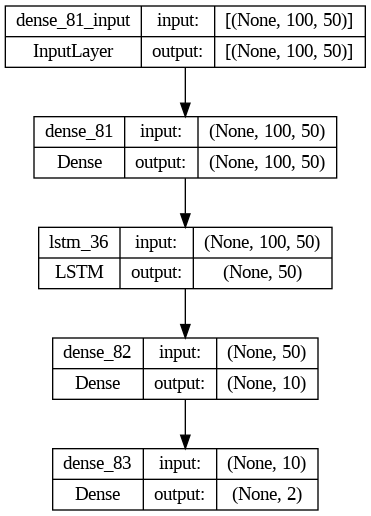

In [ ]:
#MODEL 1 (Working kinda ok)
model_RNN = Sequential()
model_RNN.add(Dense(50, input_shape = (100,50)))
#model_RNN.add(Embedding(input_dim=380891, output_dim=50, input_length=100))
model_RNN.add(LSTM(50))
model_RNN.add(Dense(10, activation='relu'))
model_RNN.add(Dense(2, activation = 'sigmoid'))

model_RNN.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model_RNN.fit(X_test, y_test,
          validation_data=(X_test, y_test), 
          callbacks=[monitor],
          verbose=2, 
          epochs=100,
          batch_size=32)  

m_pred = model_RNN.predict(X_test)
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model_RNN.summary())
# plot graph
plot_model(model_RNN, show_shapes=True)

In [ ]:
#model_RNN.save(filepath, 'RNN_model')

In [ ]:
layer = model_RNN.layers[0]
layer

In [ ]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model_RNN,
                          layer=layer,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

In [ ]:
x_test_sample = X_test[:nb_samples]
predictions = model_RNN(x_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(x_test_sample,
                         baselines=None,
                         target=predictions,
                         attribute_to_layer_inputs=False)

In [ ]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 0},
 'version': '0.9.2'}

In [ ]:
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [ ]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100, 50)


In [ ]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100)


In [ ]:
i = 1
x_i = x_test_sample[i]
attrs_i = attrs[i]
pred = predictions[i]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

In [ ]:
print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))

Predicted label =  1: Positive review


In [ ]:
words = []
for i in range(100):
  if(word2vec_model.wv.similar_by_vector(X[0][i], topn = 1)[0][1]!=0.0):
    words.append(word2vec_model.wv.similar_by_vector(X[3][i], topn = 1)[0][0])

print(words)

['the', 'name', 'says', 'it', 'all', 'but', "don't", 'get', 'fooled', 'by', 'the', 'seemingly', 'normal', 'title', 'of', 'the', 'game', "you'll", 'know', 'it', 'when', 'you', 'play', 'it', 'any', 'person', 'who', 'plays', 'this', 'game', 'including', 'me', 'has', 'the', 'right', 'to', 'say', 'that', 'this', 'free', 'horror', 'entertainment', 'is', 'spooky', 'me', 'the', 'the', 'the']


In [ ]:
colors = colorize(attrs_i)

HTML("".join(list(map(hlstr, words, colors))))

<ipython-input-113-931a19a490c6>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


Epoch 1/50
117/117 - 2s - loss: 0.6945 - accuracy: 0.5949 - val_loss: 0.6645 - val_accuracy: 0.6047 - 2s/epoch - 16ms/step
Epoch 2/50
117/117 - 0s - loss: 0.6394 - accuracy: 0.6339 - val_loss: 0.5789 - val_accuracy: 0.6858 - 471ms/epoch - 4ms/step
Epoch 3/50
117/117 - 0s - loss: 0.6220 - accuracy: 0.6470 - val_loss: 0.7073 - val_accuracy: 0.6596 - 449ms/epoch - 4ms/step
Epoch 4/50
117/117 - 0s - loss: 0.7709 - accuracy: 0.7600 - val_loss: 0.7140 - val_accuracy: 0.7294 - 448ms/epoch - 4ms/step
Epoch 5/50
117/117 - 0s - loss: 0.8899 - accuracy: 0.7710 - val_loss: 0.6409 - val_accuracy: 0.7101 - 453ms/epoch - 4ms/step
Epoch 6/50
117/117 - 0s - loss: 0.6947 - accuracy: 0.7862 - val_loss: 1.0842 - val_accuracy: 0.7244 - 446ms/epoch - 4ms/step
Epoch 7/50
117/117 - 0s - loss: 0.9017 - accuracy: 0.8028 - val_loss: 1.0623 - val_accuracy: 0.7425 - 455ms/epoch - 4ms/step
Epoch 7: early stopping
51/51 [==============================] - 0s 2ms/step
              precision    recall  f1-score   supp

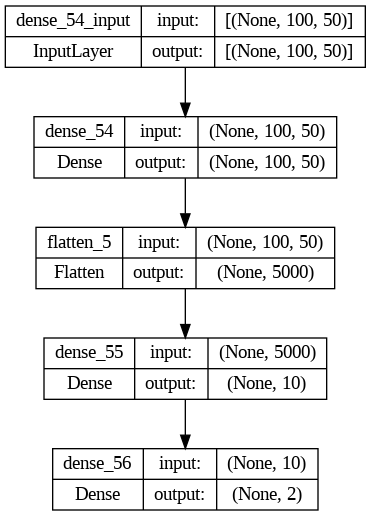

In [ ]:
#MODEL 2 (WORKS WELL)
model = Sequential()
model.add(Dense(50, input_shape= (100,50), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(2))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)

model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks = [monitor, checkpointer],verbose=2,epochs=50)

m_pred = model.predict(X_test)
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

In [ ]:
#model.save(filepath, 'seq_model')

In [ ]:
layer = model.layers[0]
layer

In [ ]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model,
                          layer=layer,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

In [ ]:
x_test_sample = X_test[:nb_samples]
predictions = model(x_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(x_test_sample,
                         baselines=None,
                         target=predictions,
                         attribute_to_layer_inputs=False)

In [ ]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 0},
 'version': '0.9.2'}

In [ ]:
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [ ]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100, 50)


In [ ]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100)


In [ ]:
i = 1
x_i = x_test_sample[i]
attrs_i = attrs[i]
pred = predictions[i]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

In [ ]:
print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))

Predicted label =  1: Positive review


In [ ]:
words = []
for i in range(100):
  if(word2vec_model.wv.similar_by_vector(X[0][i], topn = 1)[0][1]!=0.0):
    words.append(word2vec_model.wv.similar_by_vector(X[3][i], topn = 1)[0][0])

print(words)

['the', 'name', 'says', 'it', 'all', 'but', "don't", 'get', 'fooled', 'by', 'the', 'seemingly', 'normal', 'title', 'of', 'the', 'game', "you'll", 'know', 'it', 'when', 'you', 'play', 'it', 'any', 'person', 'who', 'plays', 'this', 'game', 'including', 'me', 'has', 'the', 'right', 'to', 'say', 'that', 'this', 'free', 'horror', 'entertainment', 'is', 'spooky', 'me', 'the', 'the', 'the']


In [ ]:
colors = colorize(attrs_i)

HTML("".join(list(map(hlstr, words, colors))))

<ipython-input-82-931a19a490c6>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


#Word Embeddings (Bert) 
Context Sensitive embeddings
Only classification works. Word attribution still needs work.


In [62]:
#Create a test set for the Bert Model from our training set.
df_test = df_train.sample(frac = .2, random_state = 2)
df_train = df_train.drop(df_test.index)

In [63]:
df_test.shape

(1336, 5)

In [64]:
df_train.shape

(5346, 5)

In [65]:
#Example of how to use the tokenizer to take the full review, tokenize it, and then get the integer id's for each token.
sentences = df_train.user_review.values
labels = df_train.user_suggestion.values
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Print the original sentence.
print(' Original: ', sentences[0])

#Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

#Print the sentence mapped to token ids.
#NOTE: This is not the embedding, which is what we need for Alibi.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!
Tokenized:  ['great', 'game', ',', 'fun', 'and', 'colorful', 'and', 'all', 'that', '.', 'a', 'side', 'note', ',', 'though', ':', 'when', 'are', 'we', 'getting', 'window', '##ed', 'mode', '?', 'my', 'computer', 'hates', 'full', '##screen', 'so', '.', '.', '.', '.', 'yeah', '.', 'the', 'computer', 'doesn', "'", 't', 'like', 'to', 'run', 'this', '.', 'shame', ',', 'because', 'this', 'is', 'really', 'enjoyable', '.', 'but', 'until', 'then', ',', 'i', 'guess', 'i', "'", 'll', 'settle', 'for', 'more', 'sky', '##rim', '.', 'cheers', '!']
Token IDs:  [2307, 2208, 1010, 4569, 1998, 14231, 1998, 2035, 2008, 1012, 1037, 2217, 3602, 1010, 2295, 1024, 2043, 2024, 2057, 2893, 3332, 2098, 5549, 1029, 2026, 3274, 

In [66]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

#Format the sentence into a way that Bert requires.
#Add the SEP and CLS markers for each sentence.
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                        
                        add_special_tokens = True,  
                        max_length = 100,           #Should match the max sentence length.
                        truncation = True,         
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',      
                   )
    
    #Append each sentence to the list    
    input_ids.append(encoded_dict['input_ids'])
    
    #Append the indexes where the 0's need to be added for padding.
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

#EXAMPLE: Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!
Token IDs: tensor([  101,  2307,  2208,  1010,  4569,  1998, 14231,  1998,  2035,  2008,
         1012,  1037,  2217,  3602,  1010,  2295,  1024,  2043,  2024,  2057,
         2893,  3332,  2098,  5549,  1029,  2026,  3274, 16424,  2440, 18182,
         2061,  1012,  1012,  1012,  1012,  3398,  1012,  1996,  3274,  2987,
         1005,  1056,  2066,  2000,  2448,  2023,  1012,  9467,  1010,  2138,
         2023,  2003,  2428, 22249,  1012,  2021,  2127,  2059,  1010,  1045,
         3984,  1045,  1005,  2222,  7392,  2005,  2062,  3712, 20026,  1012,
        21250,   999,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,   

In [67]:
#Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

#Create a 90/10 split for training and validation. NOT THE TEST SET.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,811 training samples
  535 validation samples


In [68]:
batch_size = 32

#Dataloader for training set.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

#Dataloader for validation set.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [69]:
#Load BertForSequenceClassification, the pretrained BERT model 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   #Our output labels for classification 
    output_attentions = False, 
    output_hidden_states = False, #Needed to be true for returning the embedding layer. Leave it false though for less memory usage.
)
#Run the model on GPU (faster)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [70]:
#Set the optimizer for the model.
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 4

#Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [71]:
# If there's a GPU available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')
    device = torch.device("cpu")

Using GPU: Tesla T4


In [72]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
  total_train_loss = 0
  t0 = time.time()
  #Training pass
  model.train()
  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #Resets all gradients before backwards pass. might want to remove
    model.zero_grad()  

    output = model(b_input_ids, 
                   token_type_ids=None, 
                   attention_mask=b_input_mask, 
                   labels=b_labels).to_tuple()

    
    loss = output[0] 
    logits = output[1] 
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
  
  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time() - t0)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  
  #Evaluation pass
  t0 = time.time()
  model.eval()
  
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in validation_dataloader:  
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      output2 = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      labels=b_labels).to_tuple()
    loss = output2[0]
    logits = output2[1]
    total_eval_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)
  
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  validation_time = format_time(time.time() - t0)
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))
  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


  Average training loss: 0.39
  Training epcoh took: 0:01:15
  Accuracy: 0.88
  Validation Loss: 0.29
  Validation took: 0:00:03

  Average training loss: 0.20
  Training epcoh took: 0:01:14
  Accuracy: 0.88
  Validation Loss: 0.29
  Validation took: 0:00:03

  Average training loss: 0.12
  Training epcoh took: 0:01:14
  Accuracy: 0.90
  Validation Loss: 0.31
  Validation took: 0:00:03

  Average training loss: 0.07
  Training epcoh took: 0:01:15
  Accuracy: 0.89
  Validation Loss: 0.38
  Validation took: 0:00:03


In [73]:
if isinstance(model, BertForSequenceClassification):
    # The model is an instance of BertForSequenceClassification and has an 'inputs' attribute
    print('yes')
else:
   print('no')

yes


In [74]:
#Display some stats
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.386643,0.286841,0.880914,0:01:15,0:00:03
2,0.203732,0.294887,0.882753,0:01:14,0:00:03
3,0.124268,0.309265,0.904811,0:01:14,0:00:03
4,0.073130,0.378228,0.891944,0:01:15,0:00:03


In [75]:
#For the Test dataset
sentences = df_test.user_review.values
labels = df_test.user_suggestion.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',     
                   )
        
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [90]:
#Prediction on test set
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  #Telling the model not to compute or store gradients, saving memory and 
  #speeding up prediction
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)


In [91]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

In [92]:
print(classification_report(flat_predictions, flat_true_labels))


              precision    recall  f1-score   support

           0       0.84      0.85      0.85       507
           1       0.91      0.90      0.91       829

    accuracy                           0.88      1336
   macro avg       0.88      0.88      0.88      1336
weighted avg       0.88      0.88      0.88      1336



In [93]:
#Trying to incorporate our Bert Model with Alibi's IntegratedGradients Function.
#NOTE: They are incompatible because the IG function is expecting a tf.keras model with an "inputs" attribute.
#Bert models do not have this attribute and passing in the raw inputs won't work either because it is expecting the model along with its embedding layer.
#Therefore, another Integrated Gradient function such as Captum's, which is compatible with bert, needs to be used instead.
embedding_layer = model.bert.embeddings
model = model.to('cpu')
embeddings = embedding_layer(input_ids)

n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model,
                          layer=embedding_layer,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

AttributeError: ignored